In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1


In [3]:
from IPython.display import clear_output


!pip install imutils
!pip install tensorflow-gpu==2.0.0

clear_output()

In [4]:
!python3 -m pip install tensorflow
clear_output()

In [5]:
import os

import cv2
import imutils as imutils
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning
from tqdm import tqdm # make your loops show a smart progress meter 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

RANDOM_SEED = 1
IMG_SIZE = (224,224)
IMG_PATH = "/content/drive/MyDrive/Code_&_Data_for_Thesis/3.Resized_Dataset"

print(os.listdir(IMG_PATH))

['val', 'test', 'train']


In [6]:
Test_Path = IMG_PATH + "/test/"
Training_Path = IMG_PATH + "/train/"
Validation_Path = IMG_PATH + "/val/"

In [7]:
def number_of_imgs(path):
  print(path)
  for value in os.listdir(path):
    print(value, "has", len(os.listdir(path + value)), "img")
    print("\n")

number_of_imgs(Test_Path)
number_of_imgs(Training_Path)
number_of_imgs(Validation_Path)

/content/drive/MyDrive/Code_&_Data_for_Thesis/3.Resized_Dataset/test/
Non-COVID has 550 img


COVID has 405 img


/content/drive/MyDrive/Code_&_Data_for_Thesis/3.Resized_Dataset/train/
COVID has 3235 img


Non-COVID has 4400 img


/content/drive/MyDrive/Code_&_Data_for_Thesis/3.Resized_Dataset/val/
Non-COVID has 550 img


COVID has 404 img




In [8]:
def create_dataframe(path):
    data = []
    for value in os.listdir(path):
        for image in os.listdir(path + value + "/"):
            file_path = path + value + "/" + image
            # if COVID then set it to 1 else 0
            COVID = 1 if value == "COVID" else 0
            data.append({"path": file_path, 'COVID': COVID})
            
    df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

    return df

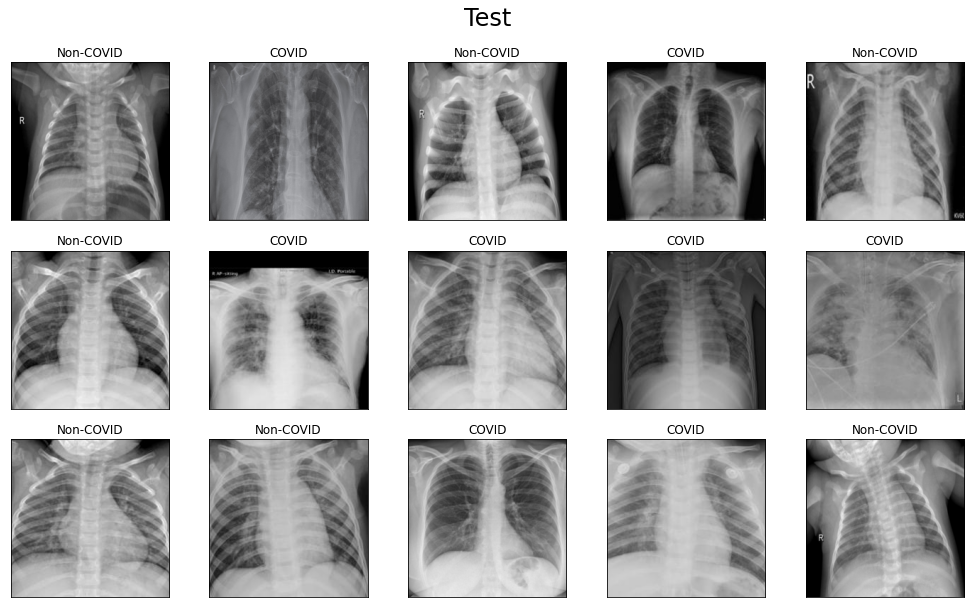

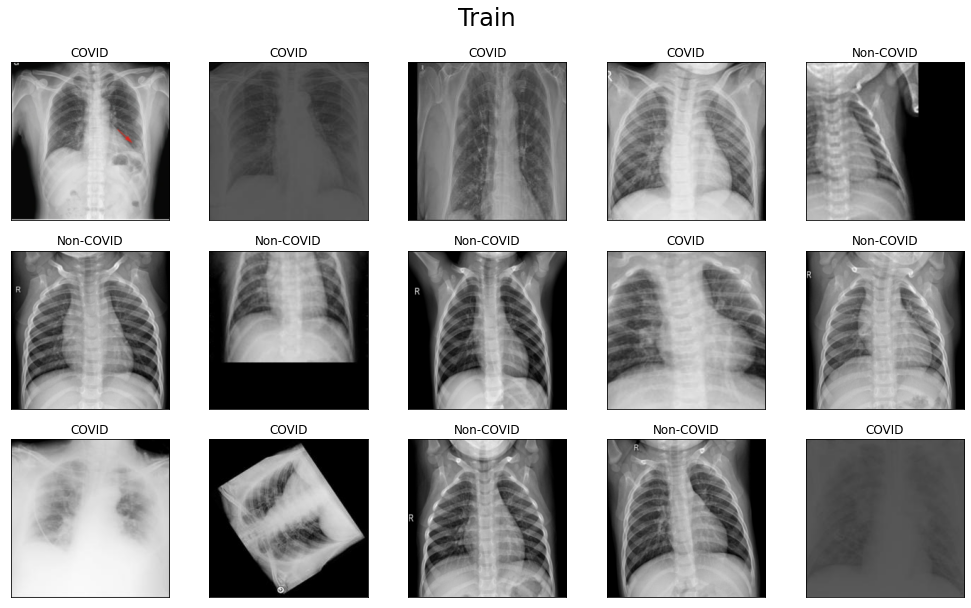

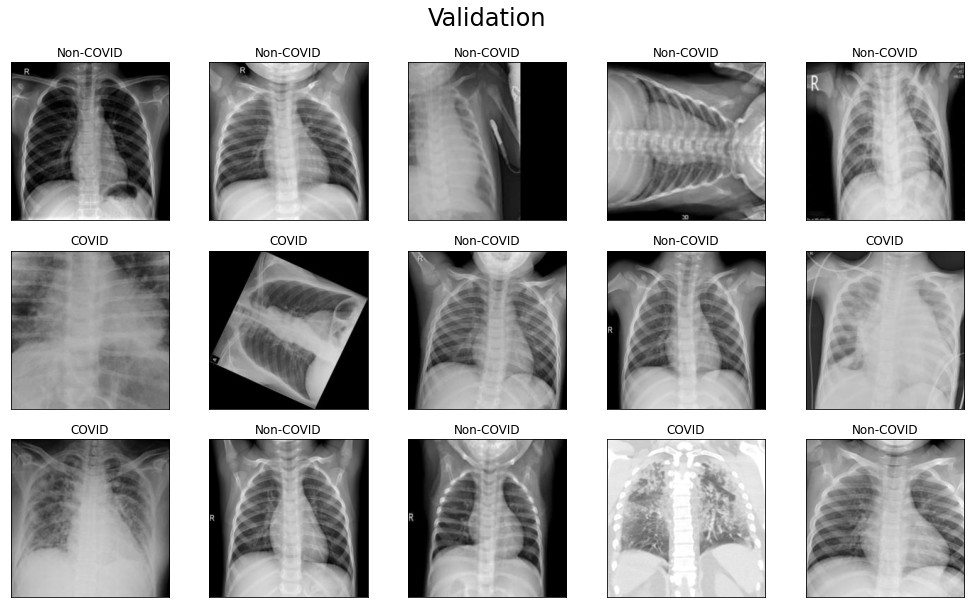

In [9]:
%matplotlib inline
def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'COVID' if row['COVID'] == 1 else 'Non-COVID'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()
    
    
plot_imgs("Test", create_dataframe(Test_Path).sample(15).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_Path).sample(15).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_Path).sample(15).reset_index(drop=True))

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    Training_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=14,
    class_mode='binary',
    seed=RANDOM_SEED
)
validation_generator = test_datagen.flow_from_directory(
    Validation_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=7,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 7630 images belonging to 2 classes.
Found 952 images belonging to 2 classes.


In [12]:
resnet50_weight_path = '/content/drive/MyDrive/Pre-Train-Models/ResNet-50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping]
)

print("Training Done")
model.save("Resnet50-Initial_Training_Xray_Original.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
50/50 [==============================] - 270s 5s/step - loss: 1.5447 - accuracy: 0.8343 - val_loss: 1.2594 - val_accuracy: 0.8686
Epoch 2/30
50/50 [==============================] - 230s 5s/step - loss: 1.1380 - accuracy: 0.8857 - val_loss: 0.6870 - val_accuracy: 0.9200
Epoch 3/30
50/50 [==============================] - 213s 4s/step - loss: 1.0882 - accuracy: 0.9029 - val_loss: 0.7959 - val_accuracy: 0.9257
Epoch 4/30
50/50 [==============================] - 188s 4s/step - loss: 1.4824 - accuracy: 0.8929 - val_loss: 0.9303 - val_accuracy: 0.9371
Epoch 5/30
50/50 [==============================] - 172s 3s/step - loss: 0.8237 - accuracy: 0.9186 - val_loss: 1.0464 - val_accuracy: 0.9143
Epoch 6/30
50/50 [==============================] - 156s 3s/step - loss: 1.0811 - accuracy: 0.9257 - val_loss: 0.4877 - val_accuracy: 0.9371
Epoch 7/30
50/50 [==============================] - 148s 3s/step - loss: 0.9188 - accuracy: 0.9257 - val_loss: 1.8228 - val_accuracy: 0.8743
Epoch 8/30
50

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
def preprocess_imgs(path, img_size):
    set_new = []
    for value in os.listdir(path):
        for img in os.listdir(path + value):
            img = cv2.imread(path + value + "/" + img)   
            set_new.append(tf.keras.applications.resnet50.preprocess_input(img))   
    return np.array(set_new)

test_data = preprocess_imgs(Test_Path, img_size=IMG_SIZE)

reality = []
for value in os.listdir(Test_Path):
    for img in os.listdir(Test_Path + value):
        reality.append(1) if value == "COVID" else reality.append(0)
        
predictions = model.predict(test_data)
predictions = [0 if x > 0.5 else 1 for x in predictions]

accuracy = accuracy_score(reality, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9319371727748691


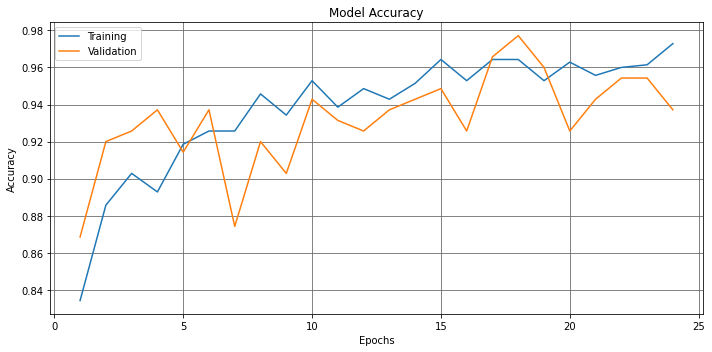

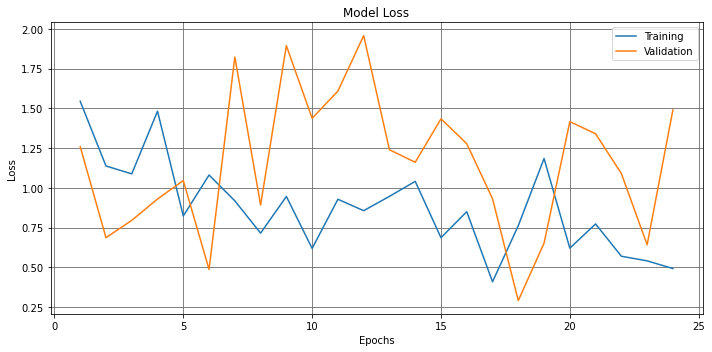

In [17]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

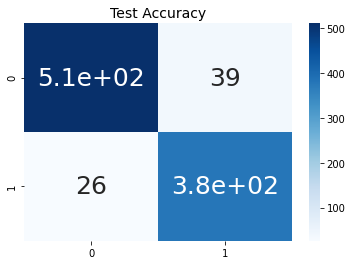

In [18]:
confusion_mtx = confusion_matrix(reality, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax)
ax.set_title('Test Accuracy', size=14)
plt.show()